In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [3]:

ex_dividend_dates = {'XOM':'2025-05-15' ,
                     'JNJ':'2025-05-27',
                     'CVX':'2025-05-19',
                     'PG':'2025-04-21',
                     'PM':'2025-03-20'}

targets = list(ex_dividend_dates.keys())

In [4]:
rawdata = pd.read_csv('../Data Sources/staggered_rollout_dividends.csv', parse_dates=['date'])

event_dates_dt = {k: pd.to_datetime(v) for k, v in ex_dividend_dates.items()}
subset = rawdata.copy()

subset = subset.sort_values(['target_ticker', 'date']).reset_index(drop=True)
subset['event_date'] = subset['target_ticker'].map(event_dates_dt)

event_indices = subset[subset['date'] == subset['event_date']].set_index('target_ticker').index

subset['row_idx'] = subset.groupby('target_ticker').cumcount()
event_idx_map = subset[subset['date'] == subset['event_date']].set_index('target_ticker')['row_idx']
subset['event_idx'] = subset['target_ticker'].map(event_idx_map)
subset['trend'] = subset['row_idx'] - subset['event_idx']

subset.tail(10)

,target,VOO,VTI,QQQ,DVY,date,target_ticker,event_date,row_idx,event_idx,trend
318,0.013957,0.006668,0.007859,0.010325,0.005034,2025-05-08,XOM,2025-05-15,56,61,-5
319,0.011690,-0.001329,-0.001114,-0.000655,-0.001079,2025-05-09,XOM,2025-05-15,57,61,-4
320,0.017240,0.033298,0.033457,0.040740,0.017203,2025-05-12,XOM,2025-05-15,58,61,-3
321,0.002748,0.006568,0.006788,0.015241,-0.002958,2025-05-13,XOM,2025-05-15,59,61,-2
322,-0.008953,0.001242,0.000657,0.005993,-0.005629,2025-05-14,XOM,2025-05-15,60,61,-1
323,0.000922,0.004906,0.004077,0.001099,0.013386,2025-05-15,XOM,2025-05-15,61,61,0
324,-0.003592,0.006449,0.006848,0.004352,0.009813,2025-05-16,XOM,2025-05-15,62,61,1
325,-0.015898,0.001025,0.000786,0.000959,0.001196,2025-05-19,XOM,2025-05-15,63,61,2
326,-0.014276,-0.003548,-0.003279,-0.003333,-0.001717,2025-05-20,XOM,2025-05-15,64,61,3
327,-0.012292,-0.016719,-0.017406,-0.013897,-0.023932,2025-05-21,XOM,2025-05-15,65,61,4


In [5]:
print(subset[subset['trend']==0])

       target       VOO       VTI       QQQ       DVY       date  \
62  -0.025405  0.001025  0.000786  0.000959  0.001196 2025-05-19   
128  0.002027  0.020548  0.020558  0.023525  0.013889 2025-05-27   
194 -0.028600 -0.023827 -0.023768 -0.024747 -0.017956 2025-04-21   
257 -0.011796 -0.002302 -0.002398 -0.003390 -0.002690 2025-03-20   
323  0.000922  0.004906  0.004077  0.001099  0.013386 2025-05-15   

    target_ticker event_date  row_idx  event_idx  trend  
62            CVX 2025-05-19       62         62      0  
128           JNJ 2025-05-27       61         61      0  
194            PG 2025-04-21       61         61      0  
257            PM 2025-03-20       58         58      0  
323           XOM 2025-05-15       61         61      0  


In [6]:
subset_2 = subset[(subset['trend'] >= -60)&(subset['trend']<=0)].copy()
subset_2['is_event_date'] = (subset_2['trend']==0).astype(int)

formula = "target~VOO+VTI+QQQ+DVY+is_event_date"
model = smf.ols(formula=formula, data=subset_2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     37.39
Date:                Sat, 28 Feb 2026   Prob (F-statistic):           1.10e-29
Time:                        15:10:43   Log-Likelihood:                 845.62
No. Observations:                 303   AIC:                            -1679.
Df Residuals:                     297   BIC:                            -1657.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0007      0.001      0.793

In [7]:
subset_3 = subset[(subset['trend'] >= -60)&(subset['trend']<4)].copy()
target_range = [-3, -2, -1, 0, 1, 2, 3]

subset_3['trend_v'] = np.where(subset_3['trend'].isin(target_range), subset_3['trend'], 99)
subset_3 = pd.get_dummies(subset_3, columns=['trend_v'], dtype=int)
subset_3 = subset_3.drop(columns=['trend_v_99'])

subset_3


,target,VOO,VTI,QQQ,DVY,date,target_ticker,event_date,row_idx,event_idx,trend,trend_v_-3,trend_v_-2,trend_v_-1,trend_v_0,trend_v_1,trend_v_2,trend_v_3
2,-0.011777,-0.017014,-0.018475,-0.020755,-0.004515,2025-02-21,CVX,2025-05-19,2,62,-60,0,0,0,0,0,0,0
3,0.006182,-0.004730,-0.005103,-0.011804,0.002122,2025-02-24,CVX,2025-05-19,3,62,-59,0,0,0,0,0,0,0
4,-0.009310,-0.004971,-0.004959,-0.012599,0.000657,2025-02-25,CVX,2025-05-19,4,62,-58,0,0,0,0,0,0,0
5,-0.008183,0.000622,0.000341,0.002416,-0.001313,2025-02-26,CVX,2025-05-19,5,62,-57,0,0,0,0,0,0,0
6,0.009862,-0.016059,-0.015492,-0.027771,-0.003360,2025-02-27,CVX,2025-05-19,6,62,-56,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,-0.008953,0.001242,0.000657,0.005993,-0.005629,2025-05-14,XOM,2025-05-15,60,61,-1,0,0,1,0,0,0,0
323,0.000922,0.004906,0.004077,0.001099,0.013386,2025-05-15,XOM,2025-05-15,61,61,0,0,0,0,1,0,0,0
324,-0.003592,0.006449,0.006848,0.004352,0.009813,2025-05-16,XOM,2025-05-15,62,61,1,0,0,0,0,1,0,0
325,-0.015898,0.001025,0.000786,0.000959,0.001196,2025-05-19,XOM,2025-05-15,63,61,2,0,0,0,0,0,1,0


In [8]:
formula = 'target~VOO+VTI+QQQ+DVY+'\
            'Q("trend_v_-3") + Q("trend_v_-2") + Q("trend_v_-1")+'\
            'trend_v_0+trend_v_1+trend_v_2+trend_v_3'
model = smf.ols(formula=formula, data = subset_3).fit()
    # cov_type='cluster', cov_kwds={'groups': subset_3['date']})
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     17.11
Date:                Sat, 28 Feb 2026   Prob (F-statistic):           2.66e-26
Time:                        15:10:43   Log-Likelihood:                 889.88
No. Observations:                 318   AIC:                            -1756.
Df Residuals:                     306   BIC:                            -1711.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0006      0.001     

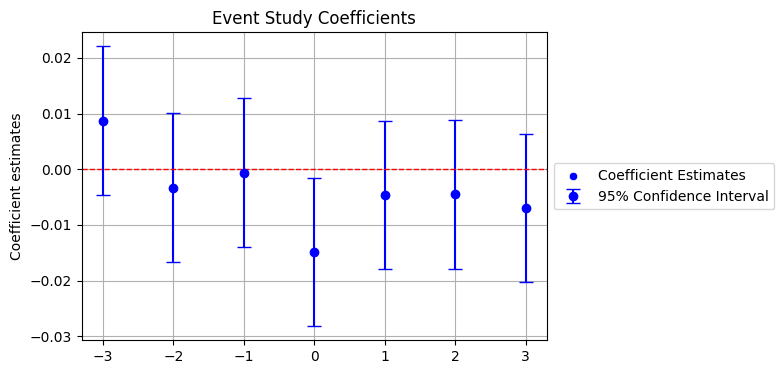

In [10]:
coefficients = model.bse.index[~model.bse.index.isin(['Intercept','VTI','VOO','QQQ', 'DVY'])]
x_values = range(-3, 4)
y_values = [model.params[coef] for coef in coefficients]
y_errors = [1.96*model.bse[coef] for coef in coefficients]


fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=x_values, y=y_values, label='Coefficient Estimates', color='b')

plt.errorbar(x_values, y_values, yerr=y_errors, fmt='o', color='b', capsize=5, label='95% Confidence Interval')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_ylabel("Coefficient estimates")
ax.set_title("Event Study Coefficients")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()